In [1]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

# for models
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import shap

from sklearn.linear_model import LogisticRegression

# display all the columns and rows 
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)
# set figure size for single graphs 
plt.rcParams['figure.figsize'] = [15, 6]

C:\Users\sasha\anaconda3\lib\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\sasha\anaconda3\lib\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\sasha\anaconda3\lib\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [30]:
raw_data = pd.read_csv('Loan_status_2007-2020Q3.gzip', nrows=7*10**5, low_memory=False)
df = raw_data.copy()

## Data prepration

In [31]:
df.filter(items=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths']).head()

,url,id,zip_code,title,emp_title,inq_fi,mths_since_recent_inq,inq_last_6mths
0,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,1077501,860xx,Computer,NaN,NaN,NaN,1.0
1,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,1077430,309xx,bike,Ryder,NaN,NaN,5.0
2,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,1077175,606xx,real estate business,NaN,NaN,NaN,2.0
3,https://lendingclub.com/browse/loanDetail.action?loan_id=1076863,1076863,917xx,personel,AIR RESOURCES BOARD,NaN,NaN,1.0
4,https://lendingclub.com/browse/loanDetail.action?loan_id=1075358,1075358,972xx,Personal,University Medical Group,NaN,NaN,0.0


In [32]:

df.drop(columns=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths'], inplace=True)

In [33]:
null_values = df.isnull().sum()
percent_nullvalues = null_values/len(df.index)*100 

In [34]:
percent_nullvalues.sort_values(ascending=False, axis=0)

hardship_loan_status                          95.710714
hardship_reason                               95.703429
hardship_status                               95.703429
hardship_end_date                             95.703143
hardship_start_date                           95.703143
hardship_type                                 95.703143
hardship_dpd                                  95.703143
hardship_length                               95.703143
payment_plan_start_date                       95.703143
deferral_term                                 95.703143
orig_projected_additional_accrued_interest    94.473429
hardship_amount                               94.385429
hardship_payoff_balance_amount                94.385429
hardship_last_payment_amount                  94.385429
sec_app_revol_util                            91.011000
verification_status_joint                     90.981571
revol_bal_joint                               90.845714
sec_app_earliest_cr_line                      90

In [35]:
df.dropna(axis=1, thresh=(1-0.50)*len(df.index), inplace=True)

#### Reason 3: Uninformative for classification
Columns bring little information for classification

Text(0.5, 0.98, 'Distribution of classes in each feature')

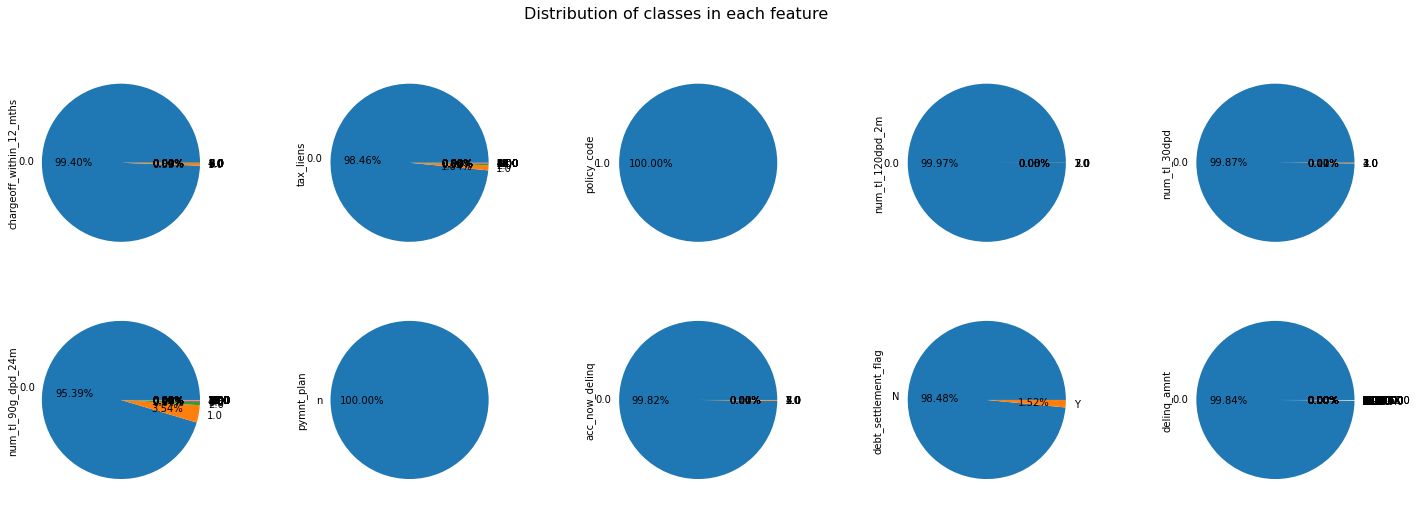

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(25, 8))

df['chargeoff_within_12_mths'].value_counts().plot.pie(ax=axs[0,0], autopct='%.2f%%')
df['tax_liens'].value_counts().plot.pie(ax=axs[0,1],autopct='%.2f%%')
df['policy_code'].value_counts().plot.pie(ax=axs[0,2],autopct='%.2f%%')
df['num_tl_120dpd_2m'].value_counts().plot.pie(ax=axs[0,3],autopct='%.2f%%')
df['num_tl_30dpd'].value_counts().plot.pie(ax=axs[0,4],autopct='%.2f%%')


df['num_tl_90g_dpd_24m'].value_counts().plot.pie(ax=axs[1,0],autopct='%.2f%%')
df['pymnt_plan'].value_counts().plot.pie(ax=axs[1,1],autopct='%.2f%%')
df['acc_now_delinq'].value_counts().plot.pie(ax=axs[1,2],autopct='%.2f%%')
df['debt_settlement_flag'].value_counts().plot.pie(ax=axs[1,3],autopct='%.2f%%')
df['delinq_amnt'].value_counts().plot.pie(ax=axs[1,4], autopct='%.2f%%')


fig.suptitle('Distribution of classes in each feature', fontsize=16)

In [37]:
df_date = df.filter(items=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'])
df_date.head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2011,Jan-1985,Jan-2015,May-2020
1,Dec-2011,Apr-1999,Apr-2013,Oct-2016
2,Dec-2011,Nov-2001,Jun-2014,Jun-2017
3,Dec-2011,Feb-1996,Jan-2015,Apr-2016
4,Dec-2011,Jan-1996,Jan-2017,Apr-2018


In [69]:
df.drop(columns=['initial_list_status', 'grade', 
                 'chargeoff_within_12_mths', 'tax_liens', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                 'num_tl_90g_dpd_24m', 'pymnt_plan', 'acc_now_delinq', 'debt_settlement_flag', 'delinq_amnt', 
                 'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d',
                ], inplace=True)

In [38]:
df.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                 'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                 'total_il_high_credit_limit', 'hardship_flag', 'installment', 
                 'revol_util','collections_12_mths_ex_med'],
                inplace=True)

#### Reason 5: High correlation - Based on Pearson correlation matrix

In [39]:
cr = df.corr().abs()
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt             loan_amnt               1.000000
fico_range_low        fico_range_high         1.000000
open_acc              num_sats                0.999278
num_rev_tl_bal_gt_0   num_actv_rev_tl         0.985851
tot_hi_cred_lim       tot_cur_bal             0.977287
total_bal_ex_mort     total_bal_il            0.903863
total_bc_limit        bc_open_to_buy          0.858792
open_rv_24m           acc_open_past_24mths    0.850912
percent_bc_gt_75      bc_util                 0.849120
open_acc              num_op_rev_tl           0.844777
num_tl_op_past_12m    open_rv_12m             0.844313
num_op_rev_tl         num_sats                0.844281
num_rev_accts         num_bc_tl               0.843111
num_actv_bc_tl        num_bc_sats             0.835555
                      num_actv_rev_tl         0.833164
                      num_rev_tl_bal_gt_0     0.827188
tot_cur_bal           avg_cur_bal             0.823470
num_rev_accts         num_op_rev_tl           0.799852
num_rev_tl

In [40]:
df.drop(columns=['num_sats','num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
                'bc_open_to_buy', 'percent_bc_gt_75', 'total_bal_ex_mort',
                'num_rev_accts', 'num_actv_bc_tl', 'num_op_rev_tl', 
                'avg_cur_bal', 'num_tl_op_past_12m', 'open_rv_24m', 'open_il_24m',
                'pub_rec_bankruptcies', 'total_rev_hi_lim', 'num_bc_sats',
                'total_acc'], inplace=True)

In [41]:
cr = df.corr().abs()
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt        loan_amnt         1.0
fico_range_high  fico_range_low    1.0
Unnamed: 0       Unnamed: 0        NaN
dtype: float64

<AxesSubplot:>

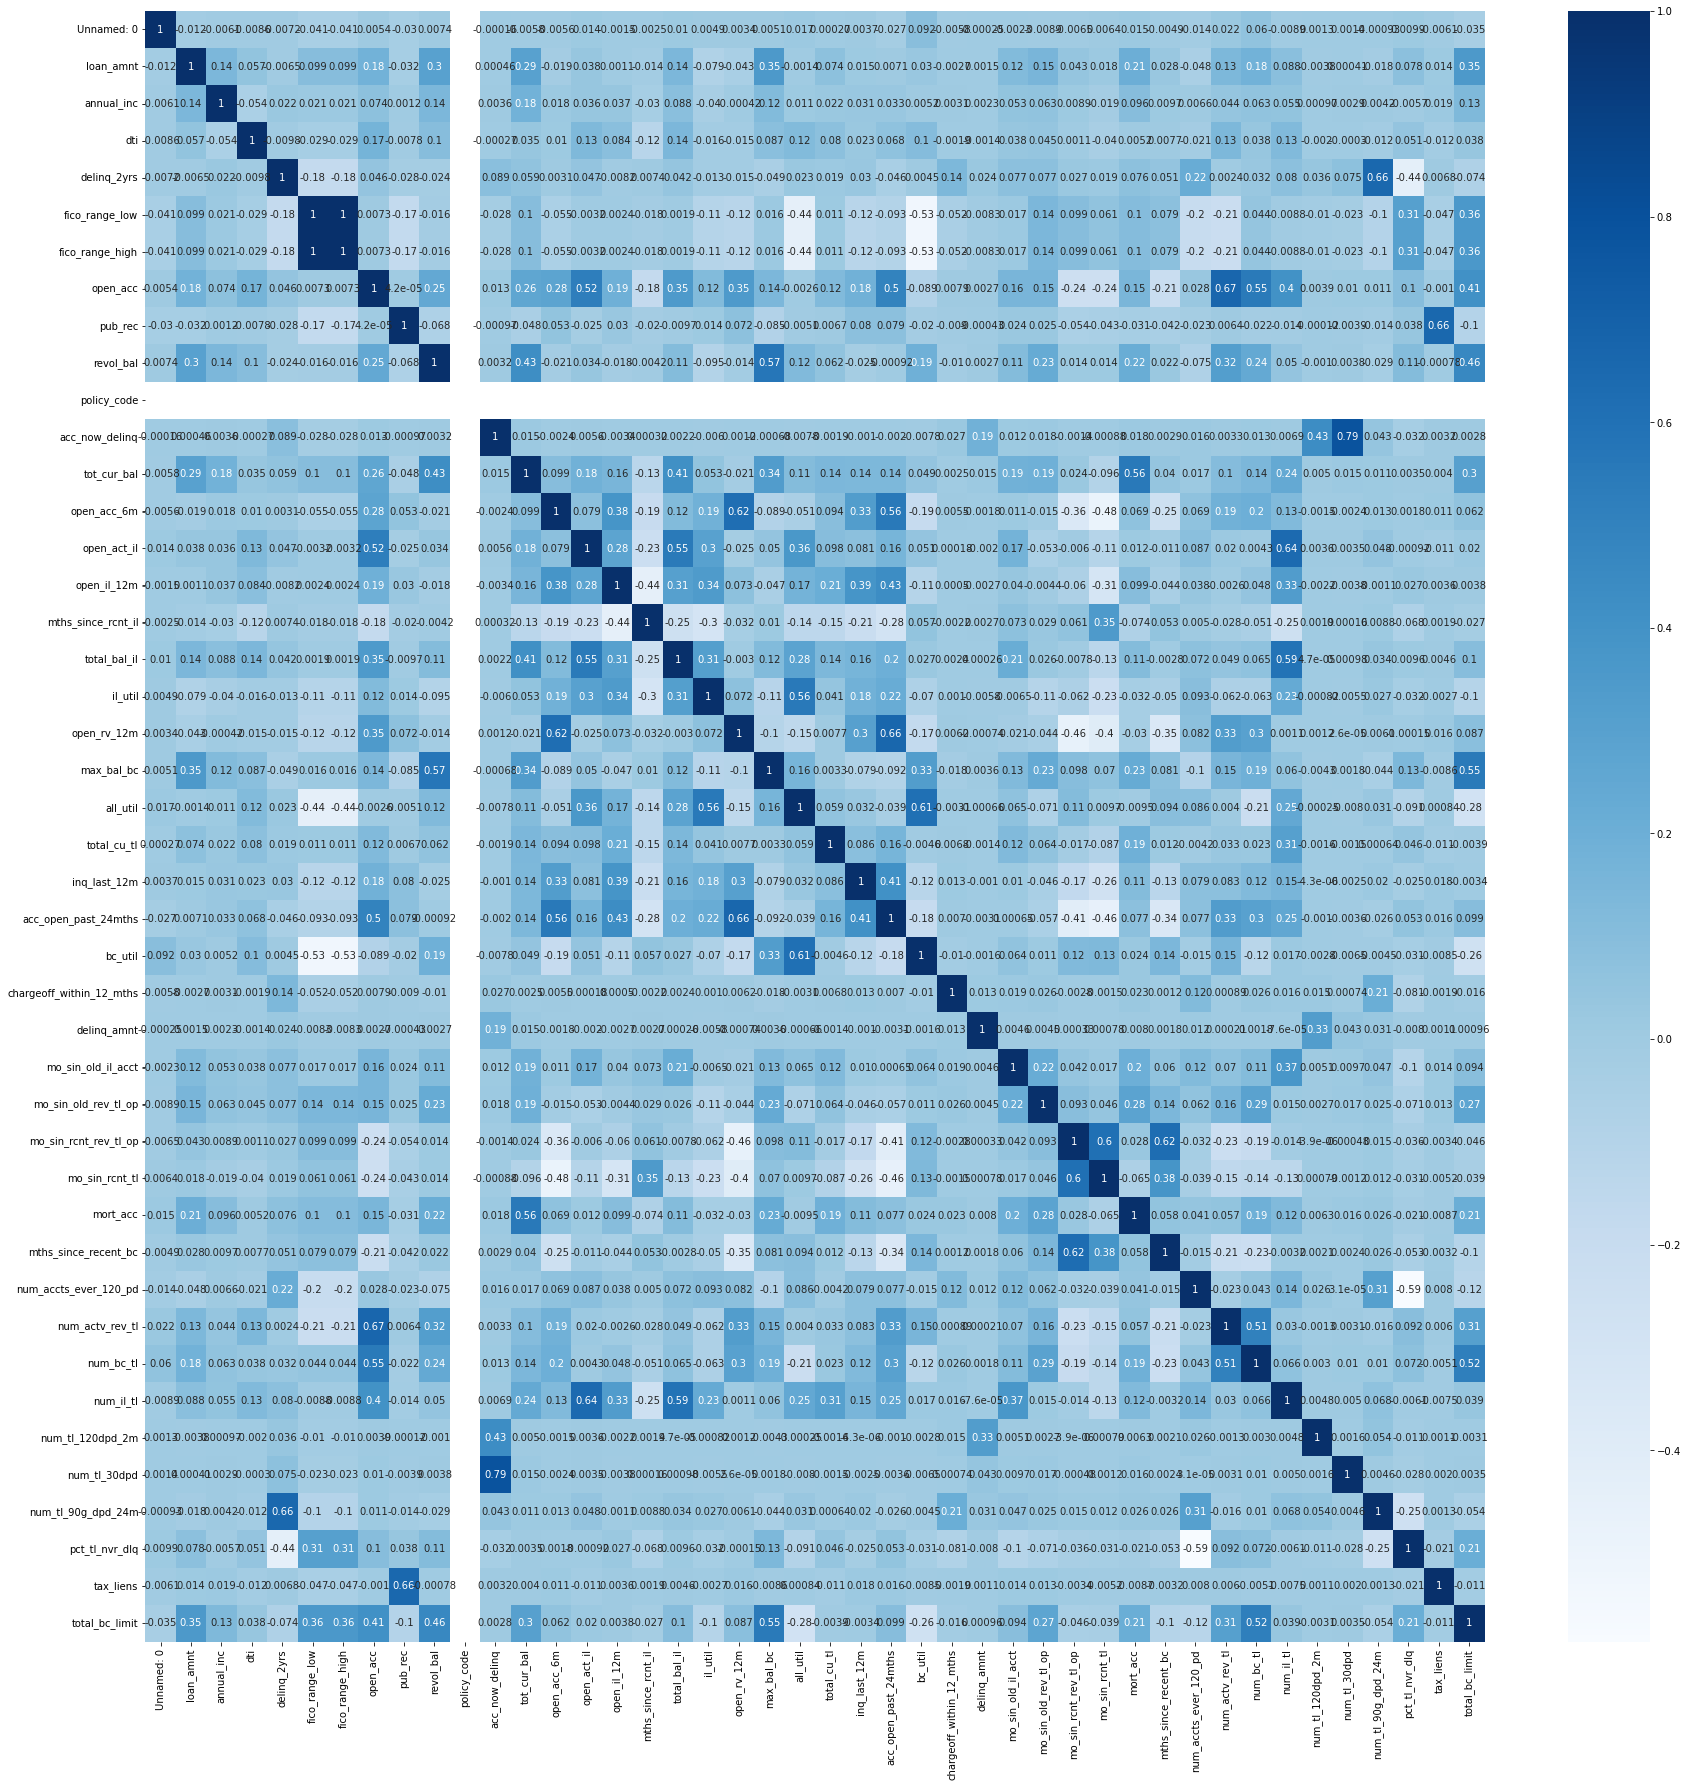

In [42]:
plt.figure(figsize=(30,30))        
sns.heatmap(df.corr(), annot=True, cmap="Blues")

In [43]:
df.duplicated(keep='first')

0         False
1         False
2         False
3         False
4         False
          ...  
699995    False
699996    False
699997    False
699998    False
699999    False
Length: 700000, dtype: bool

In [44]:
df.duplicated(keep='first').sum()

0

In [45]:
df.dropna(inplace=True)
df.isnull().sum().sort_values()

Unnamed: 0                  0
mths_since_rcnt_il          0
total_bal_il                0
il_util                     0
open_rv_12m                 0
max_bal_bc                  0
all_util                    0
total_cu_tl                 0
inq_last_12m                0
acc_open_past_24mths        0
bc_util                     0
chargeoff_within_12_mths    0
delinq_amnt                 0
mo_sin_old_il_acct          0
mo_sin_old_rev_tl_op        0
mo_sin_rcnt_rev_tl_op       0
mo_sin_rcnt_tl              0
mort_acc                    0
mths_since_recent_bc        0
num_accts_ever_120_pd       0
num_actv_rev_tl             0
num_bc_tl                   0
num_il_tl                   0
num_tl_120dpd_2m            0
num_tl_30dpd                0
num_tl_90g_dpd_24m          0
pct_tl_nvr_dlq              0
tax_liens                   0
open_il_12m                 0
open_act_il                 0
open_acc_6m                 0
tot_cur_bal                 0
loan_amnt                   0
term      

In [46]:
df.shape

(346328, 62)

In [47]:
df.dtypes.sort_values()

Unnamed: 0                    int64
mths_since_rcnt_il          float64
total_bal_il                float64
il_util                     float64
open_rv_12m                 float64
max_bal_bc                  float64
all_util                    float64
total_cu_tl                 float64
inq_last_12m                float64
acc_open_past_24mths        float64
bc_util                     float64
chargeoff_within_12_mths    float64
delinq_amnt                 float64
mo_sin_old_il_acct          float64
mo_sin_old_rev_tl_op        float64
mo_sin_rcnt_rev_tl_op       float64
mo_sin_rcnt_tl              float64
mort_acc                    float64
mths_since_recent_bc        float64
num_accts_ever_120_pd       float64
num_actv_rev_tl             float64
num_bc_tl                   float64
num_il_tl                   float64
num_tl_120dpd_2m            float64
num_tl_30dpd                float64
num_tl_90g_dpd_24m          float64
pct_tl_nvr_dlq              float64
tax_liens                   

##### Setting dummies

There are many methods but here get_dummies is used to convert categrical variables because it is fast and simple.

In [48]:
# One-hot encoding with Pandas: setting the dummies
df_xgb = pd.get_dummies(df, columns=['application_type',
                                    'addr_state',
                                    'purpose',
                                    'verification_status',
                                    'home_ownership',
                                    'emp_length',
                                    'sub_grade',
                                    'term'])
# reset index
df_xgb= df_xgb.reset_index()
# check the new data created
df_xgb.head().transpose()

,0,1,2,3,4
index,230717,230718,230719,230721,230723
Unnamed: 0,0,1,2,4,6
loan_amnt,12000.0,32000.0,40000.0,33000.0,10000.0
int_rate,7.97%,11.99%,15.05%,7.21%,9.44%
grade,A,B,C,A,B
annual_inc,42000.0,155000.0,120000.0,107000.0,55000.0
issue_d,Sep-2017,Sep-2017,Sep-2017,Sep-2017,Sep-2017
loan_status,Fully Paid,Current,Current,Late (31-120 days),Fully Paid
pymnt_plan,n,n,n,n,n
dti,27.74,12.35,31.11,19.06,18.79


In [49]:
# check the number of each label inloan_status 
df_xgb.loan_status.value_counts()

Current               155513
Fully Paid            144409
Charged Off            41030
Late (31-120 days)      2949
In Grace Period         1898
Late (16-30 days)        469
Default                   60
Name: loan_status, dtype: int64

In [50]:

a = df_xgb.loan_status.value_counts().keys()
b = ['Fully Paid', 'Charged Off']
c = list(set(a) - set(b))
c

['Default',
 'Late (16-30 days)',
 'In Grace Period',
 'Late (31-120 days)',
 'Current']

In [51]:

for k in c:
    del_index = df_xgb[df_xgb['loan_status'] == k].index
    df_xgb.drop(del_index, inplace=True)
print(df_xgb.loan_status.value_counts())
print()

Fully Paid     144409
Charged Off     41030
Name: loan_status, dtype: int64



In [52]:
print('Number of Fully Paid/ Number of Charged Off =', round(150020/45138,2))

Number of Fully Paid/ Number of Charged Off = 3.32


In [53]:
df_xgb = df_xgb.replace({"loan_status":{ "Fully Paid": 0, "Charged Off": 1}})

In [54]:
df_xgb.rename(columns={'emp_length_10+ years':'emp_length_10_more_years',
                       'emp_length_< 1 year':'emp_length_less_1_year'}, errors="raise", inplace=True)

for text in df_xgb.columns:
    new_name = text.replace(' ','_')
    df_xgb.rename(columns={text:new_name},inplace=True)

In [56]:
x = df_xgb.drop(columns=['loan_status'], axis=1).copy()

In [57]:
x.shape

(185439, 175)

Now the predictor data have 195158 rows and 157 columns

In [58]:
# assign data for y
y = df_xgb['loan_status']

#Convert y to integer type for further calculation
y = y.astype('int')
y.head()

0     0
4     0
8     0
9     1
10    0
Name: loan_status, dtype: int32

### Data split

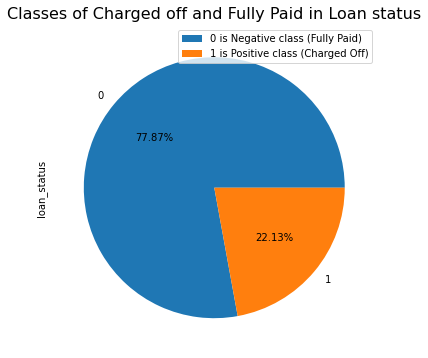

In [59]:
## Observe the imbalance data
df_xgb.loan_status.value_counts().plot.pie(autopct='%.2f%%')
plt.title('Classes of Charged off and Fully Paid in Loan status', fontsize=16)
plt.legend(labels=['0 is Negative class (Fully Paid)', '1 is Positive class (Charged Off)']) 

In [60]:
# shuffling data and split it in a stratified fashion  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y)

In [61]:
# check if the stratified sampling method works by calculating the percentage of the Charged Off class
print('Percentage of Charged Off label in y_train: ', round(sum(y_train)/len(y_train)*100, 2), '%')

Percentage of Charged Off label in y_train:  22.13 %


In [93]:
# Size of data samples
print('Independent training size (x_train):', x_train.shape)
print('Dependent training size (y_train):', y_train.shape)
print('Independent testing size (x_test):', x_test.shape)
print('Dependent testing size (y_train):', y_test.shape)

Independent training size (x_train): (136610, 157)
Dependent training size (y_train): (136610,)
Independent testing size (x_test): (58548, 157)
Dependent testing size (y_train): (58548,)


In [68]:
#df_xgb.to_csv("MODEL_READY_DATA.csv")